The core pipeline of this script involves a **descriptor-based data analysis workflow**. It first employs dimensionality reduction on the pre-processed descriptor data. Subsequently, the reduced data is visualized to reveal its structure, which informs downstream operations such as strategic sampling or the identification and exclusion of outliers.

In [1]:
from ASCF.main import ASCF
import chemiscope

In [2]:
ascf = ASCF()

# Load database
- **Input Requirement**: This workflow requires an ASE database (*.db file) as the primary input. The database should contain atomic structures and the corresponding material properties needed for analysis.
- **Database Preparation**: To ensure compatibility, please store all relevant properties in the database using a key-value pair schema. Crucially, the name or identifier of each structure is better to be saved under the key 'struc_name'.

In [3]:
ascf.load_database(f'db_NNHv_example.db')

In [4]:
ascf.database[1].key_value_pairs

{'struc_name': '100_NNHv_0_2t',
 'Eads': 0.529405225,
 'Cadsb': 1.0,
 'Csite': 0.0}

# Feature Vector Generation via Descriptors
This step generates a numerical feature vector for each atomic structure using descriptors. Currently, the script only supports the Smooth Overlap of Atomic Positions (SOAP) descriptor.  

The SOAP descriptor is calculated relative to a specific center point. The script provides multiple methods to define this point.  
see function documentation for **idntify_centers** for details

In [94]:
ascf.idntify_centers?

Signature:
ascf.idntify_centers(
    center_type='all',
    adsb_element=['N', 'H'],
    atom_height=None,
    para_infer_site={'adsb': ['N', 'H']},
    site_height=0.0,
)
Docstring:
Function to idntify atomic centers for calculation of descriptor

Parameters:
    - center_type (str): type of center atoms, in 'adsb', 'site', 'layer', 'all'. Default = 'all'
      'adsb' will selected adsorbed atomic centers according to 'adsb_element' and 'atom_height'.
      'site' will use infer_adsorption_site to selected site aomic centers then find site with 'site_height'. 
      'layer' will use selected atoms that satisfy height criterion set by 'atom_height'
      'all' will use all atoms in the structure as centers.
    - adsb_element: (list): list of adsorbate elements. Default = ['N', 'H']
    - atom_height: (list or None): a (2,) list of a height criterion to assist the determination of adsorbed atoms. Default = None
      Passing the criterion and the height corresponding to highest not sel

For the demonstration, the center is defined as **a point located 0.5 Å above the adsorption site**.

In [5]:
ascf.idntify_centers(center_type='site', adsb_element=['N', 'H'], site_height=0.5)

The SOAP descriptor is computed for the local environment around the chosen center point. The resulting vector serves as the structural fingerprint.  

All SOAP parameters are provided as a key-value dictionary stored in the variable **para_dscrib**.  

For a complete list of parameters and their physical meanings, please refer to the documentation of the external software [DScribe](https://singroup.github.io/dscribe/latest/tutorials/descriptors/soap.html).

In [6]:
ascf.describe_atom_environment(para_dscrib={})

In [7]:
ascf.atom_envir_describ.shape

(636, 1800)

# Dimensionality Reduction for Visualization
In this step, the high-dimensional SOAP descriptor vectors are projected into a 2-dimensional space for visualization and pattern analysis.  

For this demonstration, we apply a two-stage reduction:  
- **Initial PCA**: First, PCA is applied to reduce dimensionality while preserving 90% of the cumulative explained variance. This step compresses noise and accelerates the subsequent step.
- **Final t-SNE**: The PCA-reduced features are then fed into t-SNE for non-linear projection to the final 2D space.

In [74]:
ascf.perform_dimension_reduction(reduct_seq=['PCA', 'tSNE'], dimension=[0.90, 2], para_tSNE={'random_state': 1})

In [75]:
ascf.low_dimensional_describe.shape

(636, 2)

The reduction is performed by directly calling the corresponding functions from sklearn. You can inspect the source code (perform_dimension_reduction() function) to use alternative methods and modify hyperparameters.  

# Visualizing the Feature Distribution
After dimensionality reduction, you can now visualize the distribution of your material structures in the 2D latent space. This step helps identify clusters, trends, and outliers in your dataset.

The script provides two complementary visualization methods, catering to different analysis needs:  

- Static 2D Scatter Plot: This method generates a publication-quality static plot using **Matplotlib**. It is ideal for quick inspection and figure generation.
- Interactive Exploration (Chemiscope): For deep interactive analysis, we integrate with **Chemiscope**, a powerful web-based visualization tool specifically designed for materials and atomic structures.

Here show two different methods for visualizaing with adsorption energy as point color.

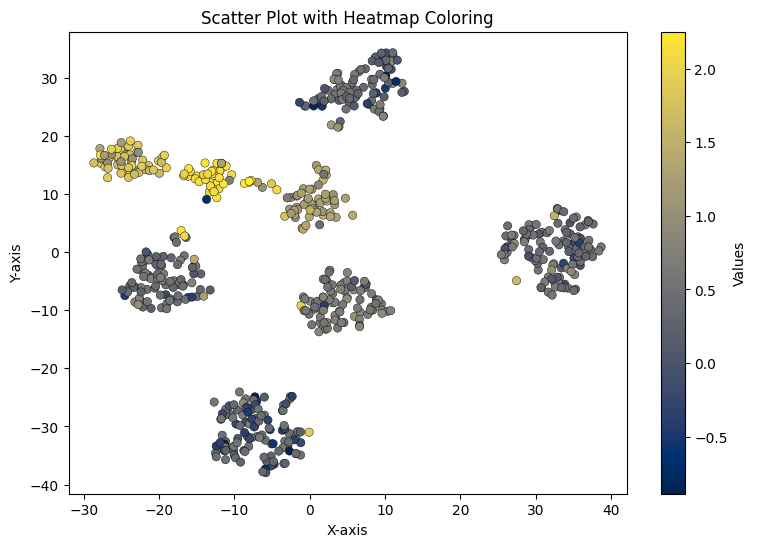

In [76]:
ascf.plot_scatter(color_by='Eads')

In [77]:
ascf.prepare_chemiscope_input(color='Eads')

In [78]:
chemiscope.show(**ascf.chemiscope_input)

<ChemiscopeWidget(meta={'name': 'Geometric feature projection'}, settings={'map': {'x': {'property': 'PCA[1]'}…

# Strategic Data Sampling

After visualizing the data distribution, you may want to select a representative subset of structures for further analysis or computationally expensive simulations. This step implements strategic sampling methods to efficiently select diverse and informative data points.  

The script provides two complementary sampling strategies:
- **Farthest Point Sampling (FPS)**: Iteratively selects points that are maximally distant from already chosen points.
- **Stratified Sampling**: Divides the dataset into distinct groups (strata) based on a feature vector and samples proportionally from each group.

In this example, we apply both methods to select 300 representative structures from our dataset of 636 NNH adsorption configurations.  

Note that during sampling, the dimensionality does not necessarily have to be 2 (**at most 8**). Sampling can be performed in a medium-dimensional space first, and then the data can be reduced to 2 dimensions for visualization.


In [22]:
ascf.perform_dimension_reduction(['PCA'], [8])

In [23]:
ascf.low_dimensional_describe.shape

(636, 8)

In [25]:
ascf.farthest_point_sampling(300)

In [27]:
ascf.stratified_sampling(300)

# Outlier Detection
The workflow includes functionality to identify outliers — data points that exhibit anomalous behavior, such as having similar feature vectors but significantly different target property values.

The script provides multiple outlier detection algorithms, details can be found by:

In [93]:
ascf.find_abnormal?

Signature:
ascf.find_abnormal(
    target,
    method='kmean-abn',
    threshold_neibor=5,
    threshold_abnormal=3,
    update=False,
    metric='euclidean',
    abnormal_method='iqr',
    random_state=66,
)
Docstring:
Find abnormal samples:

Parameters:
    - target (str): target value property
    - method (str): method to find abnormal samples. Default = 'kmean-std'
      'kmean-abn', 'dbscan-abn': classify points by K-mean (n_cluster=int threshold_neibor) or DBSCAN (eps=float threshold_neibor),
      In each class, regard points that have abs(target value - cluster_target_mean) > float threshold_abnormal * cluster_std as abnormal
      'local_similar': find the nearest k (int threshold_neibor) points or points within a distance of r (float threshold_neibor),
      calculate the z-score for the center points within its neighbors, if z-score > threshold_abnormal, regard as abnormal
    - threshold_neibor (int or float): parameter for neighbor determination. Default = 5
    - thresho

Function **k_nearst_dist** and **show_similarity_vs_targetdiff** may help you decide some input paramers on **find_abnormal**  

Here a simple method is use to identify abnormal samples.

In [79]:
ascf.perform_dimension_reduction(['PCA', 'tSNE'], [0.90, 2], para_tSNE={'random_state': 66})

In [88]:
ascf.find_abnormal(target='Eads', method='kmean-abn', threshold_neibor=8, threshold_abnormal=1.5)

Additionally, you can enable the **update** parameter during runtime, which allows multiple methods to be applied simultaneously for outlier removal.  

**Note that** if you plan to remove outliers before sampling, you must follow this sequence:
- **Detect outliers** using the methods above.
- **Save a cleaned database** that excludes the identified outliers (using the to_new_db() function provided in the follow).
- **Reload the cleaned database** as the new input.
- **Proceed with sampling** on the cleaned dataset.

# Visualize outliers or sampled data points. 
During visualization, use **select_show** to highlight specific subsets of samples, or combine parameters **show_group** (or **group_by**) and **show_group_by** (or **para_scatter2**) to simultaneously display sampled vs. unsampled, or normal vs. abnormal samples using different markers.

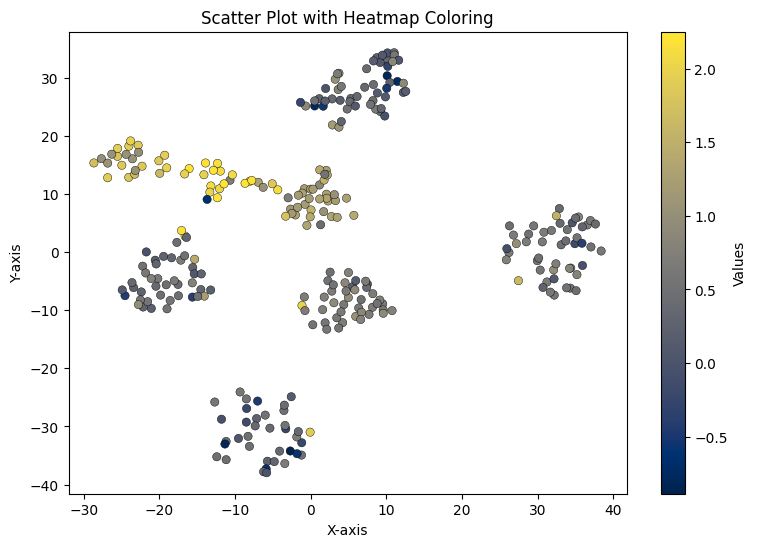

In [85]:
ascf.plot_scatter(color_by='Eads', select_show='sample')

In [89]:
ascf.prepare_chemiscope_input(color='Eads', show_group='abnormal', show_group_by='symbol')

In [90]:
chemiscope.show(**ascf.chemiscope_input)

<ChemiscopeWidget(meta={'name': 'Geometric feature projection'}, settings={'map': {'x': {'property': 'PCA[1]'}…

# Save structures
The script provides two methods for saving new structures: one saves as an ASE database (**to_new_db**), and the other exports direct structure files (**write_files**). By modifying the **file** parameter, you can select the type of samples to save (all, sampled, or non-outlier). For detailed usage, please refer to the function documentation.

In [91]:
ascf.to_new_db?

Signature: ascf.to_new_db(new_db, files='normal')
Docstring:
Make sampled or normal structure to a new ASE database.

Parameter:
    - new_db (filt path): name and path to the new ASE database
    - files (str): 'sample' or 'normal'. Default = 'normal'
File:      f:\jupyter-work-path\hea-gnn-train\ascf\main.py
Type:      method

In [92]:
ascf.write_files?

Signature:
ascf.write_files(
    write_path,
    files='all',
    file_format='vasp',
    file_suffix=None,
    file_names=None,
)
Docstring:
write sampled structures

Parameters:
    - write_path (path): path to store outputs
    - files (str): files to write, 'all', 'sample' or 'normal'. Default = 'all'
    - file_format (str): write file format (file_format on ase.os.write). Default = vasp
    - file_suffix (str or None): whether add suffix to file name. Default = None
    - file_names ((len(db), ) list or None): list of file names. If None, use row.struc_name (use row.id if struc_name not exist). Default = None
File:      f:\jupyter-work-path\hea-gnn-train\ascf\main.py
Type:      method